In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.optimize import curve_fit
import scipy.stats as stat

In [2]:
R = 3300.0
Rsig = 17.5

Rl = 151.0
Rlsig =2.755

L = 25E-3
Lsig = 5E-3

In [3]:
RCLdata = pd.read_csv('CSVs/dataChaos.csv')

# Create some series 
# voltage
Vin = RCLdata['VIn CH1']
VinSig = RCLdata['VInSig']

Vout = RCLdata['VOut CH2']
VoutSig = RCLdata['VOutSig']

#Frequency and Angular Freq
Freq = RCLdata['Frequency Hz']
FreqSig = RCLdata['FeqSig Hz']
w = RCLdata['w']
wSig =RCLdata['wSig']

#Phase angle & parameters 
Phi = RCLdata['Phase Ch2Ch1 deg']
Phivar = RCLdata['PhaseVar deg']

Period = RCLdata['Period s']
Periodsig = RCLdata['PeriodSig s']
Timdiff = RCLdata['Timediff TD s']
Timdiffsig = RCLdata['TDSig s']

In [4]:
#for data manipulation -not curvefit
def Phasedeg(timediff, period): 
    """ Input time difference between waves & period of output wave
        Return the phase angle in degrees"""
    phi = 360*(timediff/period)
    return phi


def PhaseVardeg(timediff, tdsig, period, psig): 
    """ Input the time differnce, tdsig, period, psig 
        Returns the Variance of the phase angle in degress"""
    tdvar = tdsig**2
    pvar = psig**2

    t1 = 360/period
    term1 = (t1**2)*tdvar
    
    t2 = (360*timediff)/(period**2)
    term2 = (t2**2)*pvar

    phivar = term1 + term2
    return phivar

In [5]:
#for data manipulation -not curvefit
def R_tVar(Rsig, RLsig):
    RtVar = Rsig**2 + RLsig**2 
    return RtVar

Rt = R + Rl
Rtvar = R_tVar(Rsig, Rlsig)
Gamma = Rt/L

In [6]:
#check excel calculated correctly 
phi2 = Phasedeg(Timdiff,Period) # missing negastives 
phi2var = PhaseVardeg(Timdiff,Timdiffsig, Period, Periodsig)
phistd = np.sqrt(phi2var)

$$
\omega_0 = \frac{1}{\sqrt{LC}}
$$

$$
C = \frac{1}{L\cdot \omega_0^2}
$$

In [7]:
# guess from FFT 
f0 = 200_000
w0 = 2*np.pi*f0
C = 1/(L*w0**2)
print(C)

2.5330295910584446e-11


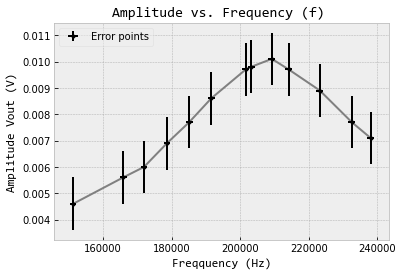

In [8]:
#style
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')

plt.plot(Freq,Vout, color= 'gray')
plt.errorbar(Freq,Vout,xerr=FreqSig, yerr=VoutSig, label = 'Error points', fmt = '.', color= 'black')


#Labels 
plt.title("Amplitude vs. Frequency (f) ", **hfont)
plt.ylabel("Amplitude Vout (V)", **hfont)
plt.xlabel("Freqquency (Hz)", **hfont)


plt.legend(loc =2,fancybox=True, framealpha=0.5)

# plt.savefig("AmpVsfreq.png", bbox_inches='tight')

In [9]:
print(f'R = \t\t{R}')
print(f'RL = \t\t{Rl}')
print(f'RT = \t\t{Rt}')
print(f'L = \t\t{L}')
print(f'C = \t\t{C}')
print(f'W0 = \t\t{w0}')
print(f'Gamma = \t{Gamma}')
print(f'f0 = \t\t{f0}')


R = 		3300.0
RL = 		151.0
RT = 		3451.0
L = 		0.025
C = 		2.5330295910584446e-11
W0 = 		1256637.0614359172
Gamma = 	138040.0
f0 = 		200000


In [10]:
# Mag. 1 
def VRMax2(w, R,w0, gamma):
    V0 = 0.00342
    return ((R*V0*w)/L)*( (w0**2-w**2)**2 + w**2*(gamma)**2)**(-1/2)

# LAST ATTEMPT
def VRMax3(w, R, L, C):
    V0 = 0.00342
    Rl = 151.0
    return ((R*V0*w)/L)*( ((L*C)**(-1) - w**2)**2 + (w**2)*((R+Rl)/L)**2)**(-1/2)


p02 = [3100,1246000,137000]
popt2 , pcov2 = curve_fit( VRMax2,w, Vout , sigma=VoutSig, p0 = p02, absolute_sigma=True, maxfev=1000, bounds = (0,(3600,1270000,140000)))
p04 = [3100,0.021,2.1E-11]
popt4 , pcov4 = curve_fit( VRMax3,w, Vout , sigma=VoutSig, p0= p04 , absolute_sigma=True, maxfev=1000, bounds=(0,(3600,0.04,3.1E-11)))

print('\nMag1 R, w0, gamma')
for i in range(0,len(popt2)):
    print('param ',i,' = ',popt2[i], '+/-', np.sqrt(np.abs(pcov2[i,i])))

print('\nMag R,L,C')
for i in range(0,len(popt4)):
    print('param ',i,' = ',popt4[i], '+/-', np.sqrt(np.abs(pcov4[i,i])))


Mag1 R, w0, gamma
param  0  =  3599.999999999857 +/- 538.6076133744148
param  1  =  1269999.9999931948 +/- 6244.700240480468
param  2  =  46659.5730788322 +/- 8115.686592387881

Mag R,L,C
param  0  =  3598.209127578964 +/- 1.277284540631166e-11
param  1  =  0.01904720083994192 +/- 0.0010124447044246633
param  2  =  3.0999999999999777e-11 +/- 3.864691022746927e-12


C:\Users\mpmun\AppData\Local\Temp\ipykernel_10320\1689976678.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return ((R*V0*w)/L)*( ((L*C)**(-1) - w**2)**2 + (w**2)*((R+Rl)/L)**2)**(-1/2)


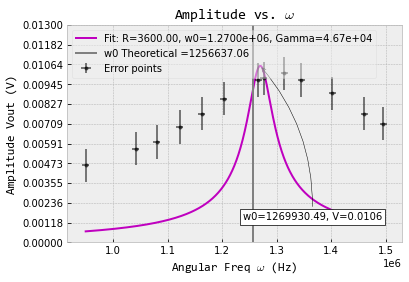

In [11]:
#style
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')


# Fit a line with paramaters given 
# fitline = VRMax2(w, *popt2)
# fitline2 = VRMax3(w, *popt4)

w_line = np.linspace(min(w), max(w), 1000)
fitline_line = VRMax2(w_line, *popt2)


def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "w0={:.2f}, V={:.4f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2", color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.14), **kw)

annot_max(w_line,fitline_line)



# plot data
plt.plot(w_line,fitline_line, 'm', label= 'Fit: R=%1.2f, w0=%1.4e, Gamma=%1.2e' % tuple(popt2))

plt.errorbar(w,Vout,yerr=VoutSig, xerr=wSig, fmt= '.', ls = None, label= 'Error points', color = 'black', alpha =0.5)
plt.yticks(np.linspace(0,.013,12))



#Labels 
plt.title("Amplitude vs. $\omega$ ", **hfont)
plt.ylabel("Amplitude Vout (V)", **hfont)
plt.xlabel("Angular Freq $\omega$ (Hz)", **hfont)
plt.axvline(w0, color ='gray', label =f'w0 Theoretical ={w0:.2f}')

plt.legend(loc =2,fancybox=True, framealpha=0.5)


plt.savefig("Graphs/AmpVsOmegachaos1.png", bbox_inches='tight')

In [12]:
# 1st for R,Wo,Gamma
# By definition: 
fitline1 = VRMax2(w,*popt2)
chisq = sum( (Vout - fitline1)**2 / VoutSig**2 )

# ndf = number of degrees of freedom
ndf = len(w)-len(popt2)

# prof advised not to use this 
chisq_reduced = chisq/float(ndf)

#   Note:
#       The reduced Chi2 = (Chi2/ndf) is just a "shortcut" that allows us to quickly decide if 
#       the data agrees with the model.
#     If reduced Chi2 is about equal to one: we are definitely good, because (Chi2/ndf)=1 corresponds to 
#     the p-value of 0.5

cdf = stat.chi2.cdf(chisq, df = ndf)

# For a Chisquare with a given number of degrees of freedom the p-test value: 
#       is just one minus the cummilative distribtion 
#       fucntion (CDF) of the chisquare probabilty distribution evaluated at the calculated value of ChiSq
pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

Chi-square:  339.73395642023104
Degrees of freedom:  10
Reduced chi-square:  33.97339564202311
CDF:  1.0
p-test value:  0.0


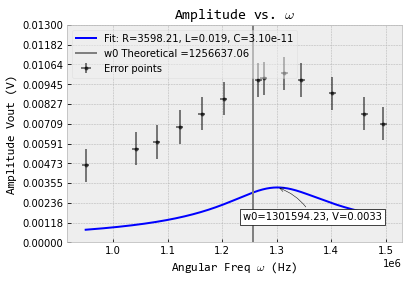

In [13]:
#style 2
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')


# Fit a line with paramaters given 
# fitline = VRMax2(w, *popt2)
# fitline2 = VRMax3(w, *popt4)

w_line2 = np.linspace(min(w), max(w), 1000)
fitline_line2 = VRMax3(w_line, *popt4)


def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "w0={:.2f}, V={:.4f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2", color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.14), **kw)

annot_max(w_line2,fitline_line2)



# plot data
plt.plot(w_line2,fitline_line2, 'b', label= 'Fit: R=%1.2f, L=%1.3f, C=%1.2e' % tuple(popt4))

plt.errorbar(w,Vout,yerr=VoutSig, xerr=wSig, fmt= '.', ls = None, label= 'Error points', color = 'black', alpha =0.5)
plt.yticks(np.linspace(0,.013,12))



#Labels 
plt.title("Amplitude vs. $\omega$ ", **hfont)
plt.ylabel("Amplitude Vout (V)", **hfont)
plt.xlabel("Angular Freq $\omega$ (Hz)", **hfont)
plt.axvline(w0, color ='gray', label =f'w0 Theoretical ={w0:.2f}')

plt.legend(loc =2,fancybox=True, framealpha=0.5)


plt.savefig("Graphs/AmpVsOmegachaos2.png", bbox_inches='tight')

In [14]:
fitline2 = VRMax3(w,*popt4)

chisq = sum( (Vout - fitline2)**2 / VoutSig**2 )

ndf = len(w)-len(popt2)

chisq_reduced = chisq/float(ndf)

cdf = stat.chi2.cdf(chisq, df = ndf)

pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

Chi-square:  449.78981153038126
Degrees of freedom:  10
Reduced chi-square:  44.97898115303813
CDF:  1.0
p-test value:  0.0


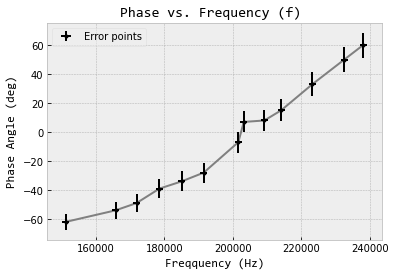

In [15]:
#style
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')

plt.plot(Freq,Phi, color= 'gray')
plt.errorbar(Freq,Phi,xerr=FreqSig, yerr=phistd, label = 'Error points', fmt = '.', color= 'black')


#Labels 
plt.title("Phase vs. Frequency (f) ", **hfont)
plt.ylabel("Phase Angle (deg)", **hfont)
plt.xlabel("Freqquency (Hz)", **hfont)

plt.legend(loc =2,fancybox=True, framealpha=0.5)

# plt.savefig("PhiVsFreq.png", bbox_inches='tight')

In [16]:
def Phifunc(w,w0,gamma):
    return (180/np.pi)*np.arctan( (w**2-w0**2)/(w*gamma) )


def Phifunc2(w,L,C,R):
    Rt = R + 151.0
    return (180/np.pi)*np.arctan( (w**2 -(L*C)**(-1) )/(w*(R+151.0)/L)  )

In [17]:
p05 = [1249000,145999]
popt5 , pcov5 = curve_fit( Phifunc,w, Phi , sigma=phistd, p0 =p05, absolute_sigma=True,maxfev=1000, bounds=(0,(1500000,150000)))
p06 = [0.013,2e-11,2922]
popt6 , pcov6 = curve_fit( Phifunc2,w, Phi , sigma=phistd, p0 =p06 ,  absolute_sigma=True, maxfev=1000, bounds=(0,(0.05,5E-11,5000)))

print('Phifunc - w0,gamma')
for i in range(0,len(popt5)):
    print('param ',i,' = ',popt5[i], '+/-', np.sqrt(np.abs(pcov5[i,i])))

print('\nPhifunc2 - L, C, R')
for i in range(0,len(popt6)):
    print('param ',i,' = ',popt6[i], '+/-', np.sqrt(np.abs(pcov6[i,i])))

Phifunc - w0,gamma
param  0  =  1272859.0791951555 +/- 5169.20240871004
param  1  =  149999.99999999997 +/- 14506.98331330103

Phifunc2 - L, C, R
param  0  =  0.022558361137712757 +/- 0.0003737662453812674
param  1  =  2.7041893778831206e-11 +/- 1.111206339525846e-12
param  2  =  4199.539161545691 +/- 1.47001395526681e-10


C:\Users\mpmun\AppData\Local\Temp\ipykernel_10320\1951680226.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return (180/np.pi)*np.arctan( (w**2 -(L*C)**(-1) )/(w*(R+151.0)/L)  )


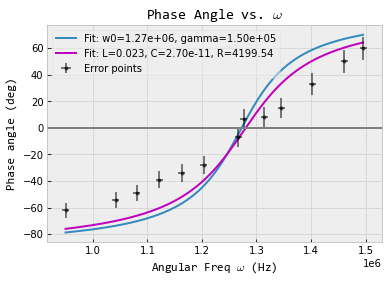

In [18]:
#style
hfont = {'fontname':'Consolas'}
plt.figure()
plt.style.use('bmh')



phifitline = Phifunc(w_line,*popt5)
phifitline2 = Phifunc2(w_line2,*popt6)


#plot data
plt.plot(w_line,phifitline, label = 'Fit: w0=%1.2e, gamma=%1.2e' % tuple(popt5))
plt.plot(w_line2,phifitline2, label = 'Fit: L=%1.3f, C=%1.2e, R=%1.2f' % tuple(popt6), color='m')
plt.errorbar(w,Phi,yerr=phistd, xerr=wSig, fmt= '.', ls = None, label= 'Error points', color = 'black', alpha =0.5)


#Labels 
plt.title("Phase Angle vs. $\omega$ ", **hfont)
plt.ylabel("Phase angle (deg)", **hfont)
plt.xlabel("Angular Freq $\omega$ (Hz)", **hfont)
# plt.axvline(w0, color ='gray', label =f'w0 Theoretical={w0:.2f}')
plt.axhline(0, color ='gray')

plt.legend(fancybox=True, framealpha=0.5)


plt.savefig("Graphs/PhiVsOmegachaos.png", bbox_inches='tight')

In [19]:
# By definition: 
phifitline = Phifunc(w,*popt5)

chisq = sum( (Phi - phifitline)**2 / phistd**2 )

# ndf = number of degrees of freedom
ndf = len(w)-len(popt6)

# prof advised not to use this 
chisq_reduced = chisq/float(ndf)

#   Note:
#       The reduced Chi2 = (Chi2/ndf) is just a "shortcut" that allows us to quickly decide if 
#       the data agrees with the model.
#     If reduced Chi2 is about equal to one: we are definitely good, because (Chi2/ndf)=1 corresponds to 
#     the p-value of 0.5

cdf = stat.chi2.cdf(chisq, df = ndf)

# For a Chisquare with a given number of degrees of freedom the p-test value: 
#       is just one minus the cummilative distribtion 
#       fucntion (CDF) of the chisquare probabilty distribution evaluated at the calculated value of ChiSq
pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

Chi-square:  100.38027994013761
Degrees of freedom:  10
Reduced chi-square:  10.038027994013762
CDF:  1.0
p-test value:  0.0


In [20]:
# By definition: 
phifitline2 = Phifunc2(w,*popt6)

chisq = sum( (Phi - phifitline)**2 / phistd**2 )

# ndf = number of degrees of freedom
ndf = len(w)-len(popt6)

# prof advised not to use this 
chisq_reduced = chisq/float(ndf)

#   Note:
#       The reduced Chi2 = (Chi2/ndf) is just a "shortcut" that allows us to quickly decide if 
#       the data agrees with the model.
#     If reduced Chi2 is about equal to one: we are definitely good, because (Chi2/ndf)=1 corresponds to 
#     the p-value of 0.5

cdf = stat.chi2.cdf(chisq, df = ndf)

# For a Chisquare with a given number of degrees of freedom the p-test value: 
#       is just one minus the cummilative distribtion 
#       fucntion (CDF) of the chisquare probabilty distribution evaluated at the calculated value of ChiSq
pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

Chi-square:  100.38027994013761
Degrees of freedom:  10
Reduced chi-square:  10.038027994013762
CDF:  1.0
p-test value:  0.0
